# **프로젝트 4: 신용거래 이상탐지 데이터 다루기**

<br>

## **프로젝트 개요 (Fraud Detection Feature Engineering)**

---

##### **프로젝트명:**

신용카드 이상거래 탐지(Fraud Detection)를 위한 데이터 전처리 및 분석



##### **목표:**

신용카드 거래 데이터(fraud.csv)에서 사기거래 여부(is_fraud)를 예측하기 위한 학습용 데이터셋을 전처리/가공한다.

##### **핵심 전략:**

단순한 거래 금액뿐만 아니라 사용자의 평소 패턴(시간, 금액, 위치) 대비 이례적인 수치를 포착할 수 있는 지표 생성

- 사기탐지는 “금액이 크다/거리가 멀다” 같은 절대값보다 개인별 평소 패턴 대비 얼마나 이례적인지(Deviation)가 더 강력한 신호가 되는 경우가 많다.

- 따라서 다음과 같은 “개인화된 이상치 지표”를 만든다.
    >- amt_z : 개인(cc_num) 기준 결제금액 Z-score
    >- cat_amt_z : 개인+업종(category) 기준 결제금액 Z-score
    >- hour_perc : 개인 기준 시간대 사용 비율(평소 활동 시간대와의 일치 정도)
    >- dist_z : 개인 기준 이동거리 Z-score (거주지~가맹점 거리의 이례성)

<br>

## **프로젝트 수행**

---

### **0. 라이브러리 로드 및 데이터 불러오기**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cc_df = pd.read_csv('/content/drive/MyDrive/DS_5th/03_비정형데이터 체험하기/20일차_1 13(화)/data/fraud.csv')
pd.set_option('display.max_columns', 50)

In [4]:
cc_df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
1,2019-01-01 00:12:34,4956828990005111019,"fraud_Schultz, Simonis and Little",grocery_pos,44.71,Kenneth,Robinson,M,269 Sanchez Rapids,Elizabeth,NJ,7208,40.6747,-74.2239,124967,Operational researcher,1980-12-21,09eff9c806365e2a6be12c1bbab3d70e,1325376754,40.079588,-74.848087,0
2,2019-01-01 00:17:16,180048185037117,fraud_Kling-Grant,grocery_net,46.28,Mary,Wall,F,2481 Mills Lock,Plainfield,NJ,7060,40.6152,-74.4150,71485,Leisure centre manager,1974-07-19,19e23c6a300c774354417befe4f31f8c,1325377036,40.021888,-74.228188,0
3,2019-01-01 00:20:15,374930071163758,fraud_Deckow-O'Conner,grocery_pos,64.09,Daniel,Escobar,M,61390 Hayes Port,Romulus,MI,48174,42.2203,-83.3583,31515,Police officer,1971-11-05,6f363661ba6b55889e488dd178f2a0af,1325377215,42.360426,-83.552316,0
4,2019-01-01 00:23:41,2712209726293386,fraud_Balistreri-Nader,misc_pos,25.58,Jenna,Brooks,F,50872 Alex Plain Suite 088,Baton Rouge,LA,70808,30.4066,-91.1468,378909,"Designer, furniture",1977-02-22,1654da2abfb9e79a5f99167fc9779558,1325377421,29.737426,-90.853194,0


<br>

### **1. 데이터 확인**

#### **1.1. 기본 구조/통계/결측 확인**

In [5]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  491134 non-null  object 
 1   cc_num                 491134 non-null  int64  
 2   merchant               491134 non-null  object 
 3   category               491134 non-null  object 
 4   amt                    491134 non-null  float64
 5   first                  491134 non-null  object 
 6   last                   491134 non-null  object 
 7   gender                 491134 non-null  object 
 8   street                 491134 non-null  object 
 9   city                   491134 non-null  object 
 10  state                  491134 non-null  object 
 11  zip                    491134 non-null  int64  
 12  lat                    491134 non-null  float64
 13  long                   491134 non-null  float64
 14  city_pop               491134 non-nu

In [6]:
cc_df.describe()

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,4.911340e+05,491134.000000,491134.000000,491134.000000,491134.000000,4.911340e+05,4.911340e+05,491134.000000,491134.000000,491134.000000
mean,3.706013e+17,69.050120,50770.532384,37.931230,-90.495619,1.213922e+05,1.358730e+09,37.930272,-90.495411,0.002533
std,1.260229e+18,160.322867,26854.947965,5.341193,12.990732,3.725751e+05,1.819402e+07,5.372986,13.004100,0.050264
min,5.038744e+11,1.000000,1843.000000,24.655700,-122.345600,4.600000e+01,1.325376e+09,23.655789,-123.345106,0.000000
25%,2.131124e+14,8.960000,28405.000000,33.746700,-97.235100,1.228000e+03,1.343087e+09,33.781388,-96.984814,0.000000
50%,3.531130e+15,42.170000,49628.000000,38.507200,-87.591700,5.760000e+03,1.357257e+09,38.545124,-87.573441,0.000000
75%,4.653879e+15,80.330000,75048.000000,41.520500,-80.731000,5.083500e+04,1.374626e+09,41.624294,-80.685567,0.000000
max,4.956829e+18,25086.940000,99323.000000,48.887800,-69.965600,2.906700e+06,1.388534e+09,49.887523,-68.965624,1.000000


In [10]:
cc_df.isna().sum().sort_values()

,0
trans_date_trans_time,0
cc_num,0
merchant,0
category,0
amt,0
first,0
last,0
gender,0
street,0
city,0


<br>

#### **1.2. 타겟 불균형 확인**

In [11]:
cc_df['is_fraud'].value_counts()

,count
is_fraud,
0,489890
1,1244


In [12]:
cc_df['is_fraud'].value_counts(normalize=True)

,proportion
is_fraud,
0,0.997467
1,0.002533


<br>

### **2. 식별자/개인정보성 컬럼 점검 및 제거**

#### **2.1. 고유값 개수(cardinality) 확인**

In [14]:
cc_df['merchant'].nunique()

693

In [15]:
cc_df['job'].nunique()

110

In [17]:
cc_df['cc_num'].nunique()

124

<br>

#### **2.2. 불필요 컬럼 제거**

In [18]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  491134 non-null  object 
 1   cc_num                 491134 non-null  int64  
 2   merchant               491134 non-null  object 
 3   category               491134 non-null  object 
 4   amt                    491134 non-null  float64
 5   first                  491134 non-null  object 
 6   last                   491134 non-null  object 
 7   gender                 491134 non-null  object 
 8   street                 491134 non-null  object 
 9   city                   491134 non-null  object 
 10  state                  491134 non-null  object 
 11  zip                    491134 non-null  int64  
 12  lat                    491134 non-null  float64
 13  long                   491134 non-null  float64
 14  city_pop               491134 non-nu

- 이름/주소/거래번호 같은 값은 모델이 “외우기”만 하고 일반화가 떨어질 수 있어 제거가 유리
- 또한 개인정보/식별자 성격이 강해 실무에서도 제거 또는 마스킹이 일반적

In [19]:
cc_df.drop(
    ['merchant','first','last','street','city','state','zip','job','trans_num','unix_time'],
    axis=1,
    inplace=True
)

In [20]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  491134 non-null  object 
 1   cc_num                 491134 non-null  int64  
 2   category               491134 non-null  object 
 3   amt                    491134 non-null  float64
 4   gender                 491134 non-null  object 
 5   lat                    491134 non-null  float64
 6   long                   491134 non-null  float64
 7   city_pop               491134 non-null  int64  
 8   dob                    491134 non-null  object 
 9   merch_lat              491134 non-null  float64
 10  merch_long             491134 non-null  float64
 11  is_fraud               491134 non-null  int64  
dtypes: float64(5), int64(3), object(4)
memory usage: 45.0+ MB


<br>

### **3. Feature Engineering 1** (개인 기준 결제금액 이례성)

#### **3.1. cc_num별 결제금액 평균/표준편차 생성 → merge**

In [21]:
# cc_num 컬럼의 값마다 amt의 평균, 표준편차를 계산하여 amt_info에 저장합니다.
amt_info = cc_df.groupby('cc_num')['amt'].agg(['mean','std']).reset_index()

In [22]:
amt_info.to_pickle('./amt_info.pkl')

In [24]:
amt_info.head()

,cc_num,mean,std
0,503874407318,60.253406,127.265783
1,567868110212,83.442558,117.303828
2,571365235126,59.392974,134.289959
3,581686439828,58.578675,149.804992
4,630423337322,56.078113,159.201852


In [25]:
# cc_num 컬럼을 기준으로, cc_df와 amt_info 데이터를 합쳐서 cc_df에 저장합니다. (left merge)
cc_df = pd.merge(cc_df, amt_info, on='cc_num', how='left')

In [26]:
cc_df.head()

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,mean,std
0,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,49.159047,-118.186462,0,56.078113,159.201852
1,2019-01-01 00:12:34,4956828990005111019,grocery_pos,44.71,M,40.6747,-74.2239,124967,1980-12-21,40.079588,-74.848087,0,59.858059,132.138802
2,2019-01-01 00:17:16,180048185037117,grocery_net,46.28,F,40.6152,-74.4150,71485,1974-07-19,40.021888,-74.228188,0,87.328067,113.454416
3,2019-01-01 00:20:15,374930071163758,grocery_pos,64.09,M,42.2203,-83.3583,31515,1971-11-05,42.360426,-83.552316,0,64.317839,174.739042
4,2019-01-01 00:23:41,2712209726293386,misc_pos,25.58,F,30.4066,-91.1468,378909,1977-02-22,29.737426,-90.853194,0,90.747123,165.470881


In [27]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  491134 non-null  object 
 1   cc_num                 491134 non-null  int64  
 2   category               491134 non-null  object 
 3   amt                    491134 non-null  float64
 4   gender                 491134 non-null  object 
 5   lat                    491134 non-null  float64
 6   long                   491134 non-null  float64
 7   city_pop               491134 non-null  int64  
 8   dob                    491134 non-null  object 
 9   merch_lat              491134 non-null  float64
 10  merch_long             491134 non-null  float64
 11  is_fraud               491134 non-null  int64  
 12  mean                   491134 non-null  float64
 13  std                    491134 non-null  float64
dtypes: float64(7), int64(3), object(4)
m

<br>

#### **3.2. Z-score 생성 (amt_z)**

In [28]:
# 결제금액(amt)의 z-score를 계산하여 amt_z 컬럼에 저장
cc_df['amt_z'] = (cc_df['amt'] - cc_df['mean']) / cc_df['std']

In [29]:
# (안전장치) std가 0이거나 NaN이면 inf/NaN 발생 가능 → 정리
cc_df['amt_z'] = cc_df['amt_z'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [122]:
cc_df['amt_z'].head()

,amt_z
0,0.321302
1,-0.114637
2,-0.361802
3,-0.001304
4,-0.393828


<br>

#### **3.3. 사기/정상에서 amt_z 분포 차이 확인**

In [40]:
# 분포 비교 (Boxplot)

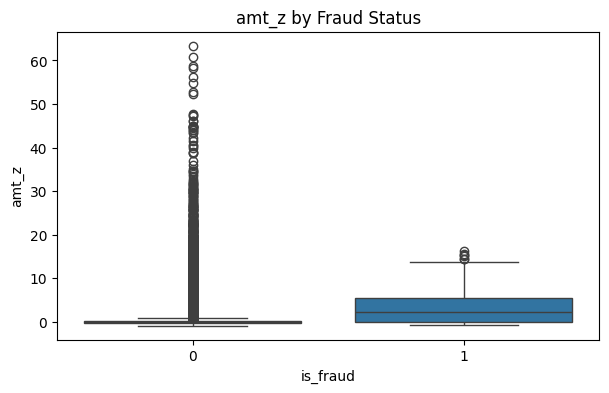

In [31]:
plt.figure(figsize=(7,4))
sns.boxplot(x='is_fraud', y='amt_z', data=cc_df)
plt.title('amt_z by Fraud Status')
plt.show()

In [41]:
# 분포 비교 (Violin)

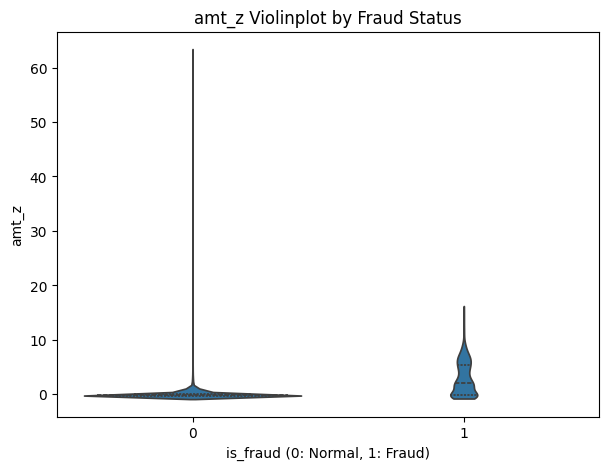

In [42]:
plt.figure(figsize=(7,5))
sns.violinplot(data=cc_df, x='is_fraud', y='amt_z', inner='quartile', cut=0)
plt.title('amt_z Violinplot by Fraud Status')
plt.xlabel('is_fraud (0: Normal, 1: Fraud)')
plt.ylabel('amt_z')
plt.show()

In [32]:
cc_df.groupby('is_fraud')['amt_z'].describe()

,count,mean,std,min,25%,50%,75%,max
is_fraud,,,,,,,,
0,489890.0,-0.007444,0.977602,-0.922785,-0.361132,-0.17814,0.093860,63.421230
1,1244.0,2.931319,3.120485,-0.817302,-0.188017,2.09175,5.380819,16.176233


In [33]:
# z-score 계산이 완료되었으니 mean, std 컬럼을 제거
cc_df.drop(['mean','std'], axis=1, inplace=True)

In [34]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  491134 non-null  object 
 1   cc_num                 491134 non-null  int64  
 2   category               491134 non-null  object 
 3   amt                    491134 non-null  float64
 4   gender                 491134 non-null  object 
 5   lat                    491134 non-null  float64
 6   long                   491134 non-null  float64
 7   city_pop               491134 non-null  int64  
 8   dob                    491134 non-null  object 
 9   merch_lat              491134 non-null  float64
 10  merch_long             491134 non-null  float64
 11  is_fraud               491134 non-null  int64  
 12  amt_z                  491134 non-null  float64
dtypes: float64(6), int64(3), object(4)
memory usage: 48.7+ MB


In [45]:
# 사기 거래 데이터(is_fraud=1)를 확인
cc_df[cc_df['is_fraud'] == 1].head()

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,amt_z
4794,2019-01-12 00:59:01,581686439828,gas_transport,11.73,M,41.5205,-80.0573,5507,1973-07-28,41.947427,-79.796264,1,-0.312731
4816,2019-01-12 03:48:07,581686439828,grocery_pos,328.68,M,41.5205,-80.0573,5507,1973-07-28,42.148618,-79.398595,1,1.803020
4979,2019-01-12 15:46:10,581686439828,food_dining,120.58,M,41.5205,-80.0573,5507,1973-07-28,42.470024,-80.126576,1,0.413880
5073,2019-01-12 19:53:59,581686439828,shopping_net,1081.35,M,41.5205,-80.0573,5507,1973-07-28,42.455406,-79.521640,1,6.827351
5124,2019-01-12 22:44:05,581686439828,shopping_net,776.70,M,41.5205,-80.0573,5507,1973-07-28,40.680209,-79.099101,1,4.793708


In [46]:
# 분포 비교: KDE(밀도) plot

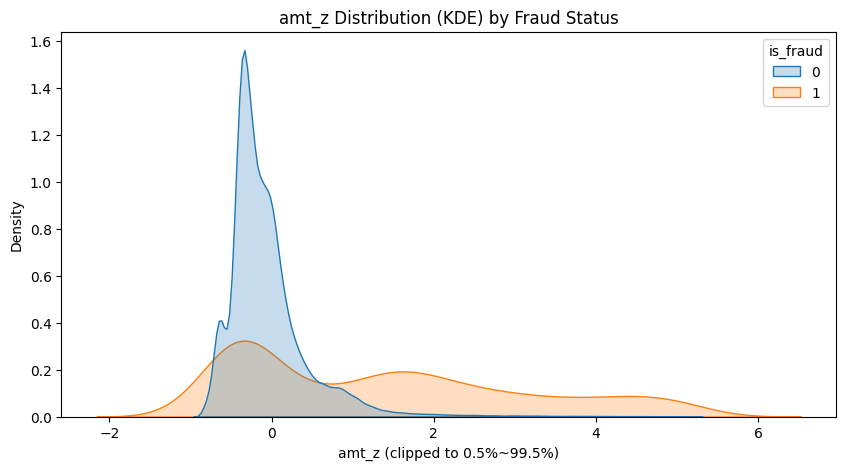

In [47]:
low, high = cc_df['amt_z'].quantile([0.005, 0.995])

plt.figure(figsize=(10,5))
sns.kdeplot(data=cc_df[(cc_df['amt_z']>=low) & (cc_df['amt_z']<=high)],
            x='amt_z', hue='is_fraud', common_norm=False, fill=True)
plt.title('amt_z Distribution (KDE) by Fraud Status')
plt.xlabel('amt_z (clipped to 0.5%~99.5%)')
plt.show()

In [49]:
# 구간을 20개로 나눔(동일 빈도 구간)

/tmp/ipython-input-229599991.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraud_rate_by_bin = tmp.groupby('amt_z_bin')['is_fraud'].mean()
/tmp/ipython-input-229599991.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_count = tmp.groupby('amt_z_bin')['is_fraud'].size()


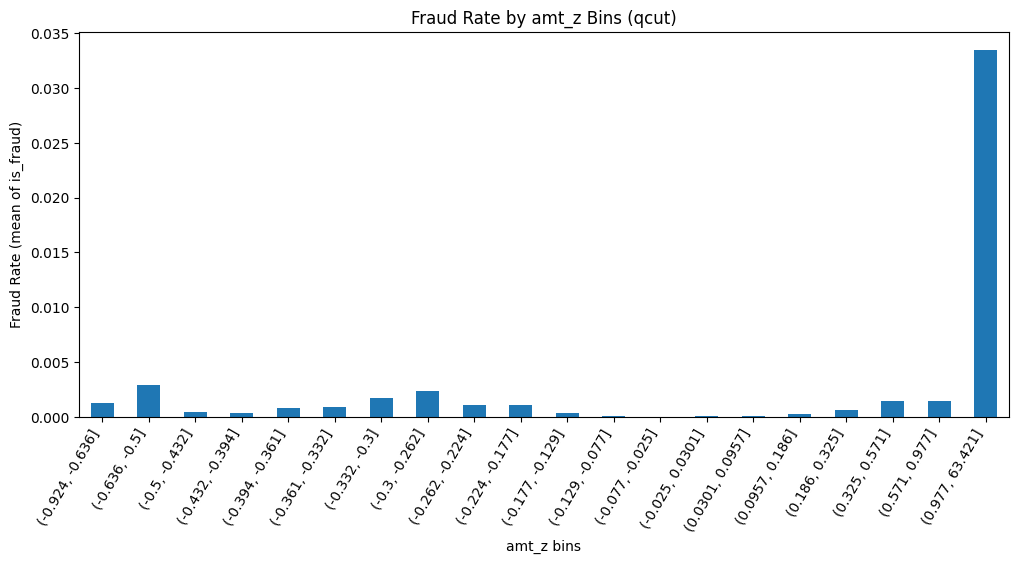

In [50]:
tmp = cc_df[['amt_z','is_fraud']].copy()
tmp['amt_z_bin'] = pd.qcut(tmp['amt_z'], q=20, duplicates='drop')

fraud_rate_by_bin = tmp.groupby('amt_z_bin')['is_fraud'].mean()
bin_count = tmp.groupby('amt_z_bin')['is_fraud'].size()

plt.figure(figsize=(12,5))
fraud_rate_by_bin.plot(kind='bar')
plt.title('Fraud Rate by amt_z Bins (qcut)')
plt.ylabel('Fraud Rate (mean of is_fraud)')
plt.xlabel('amt_z bins')
plt.xticks(rotation=60, ha='right')
plt.show()

<br>

### **4. Feature Engineering 2** (개인+업종 기준 결제금액 이례성)

#### **4.1. cc_num + category 단위 통계 생성 → merge**

In [51]:
cat_info = cc_df.groupby(['cc_num','category'])['amt'].agg(['mean','std']).reset_index()

In [52]:
cat_info.to_pickle('./cat_info.pkl')

In [53]:
# Q. cc_num 컬럼을 기준으로, cc_df와 cat_info 데이터를 합쳐서 cc_df에 저장합(left merge)
cc_df = pd.merge(cc_df, cat_info, on=['cc_num','category'], how='left')

In [54]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  491134 non-null  object 
 1   cc_num                 491134 non-null  int64  
 2   category               491134 non-null  object 
 3   amt                    491134 non-null  float64
 4   gender                 491134 non-null  object 
 5   lat                    491134 non-null  float64
 6   long                   491134 non-null  float64
 7   city_pop               491134 non-null  int64  
 8   dob                    491134 non-null  object 
 9   merch_lat              491134 non-null  float64
 10  merch_long             491134 non-null  float64
 11  is_fraud               491134 non-null  int64  
 12  amt_z                  491134 non-null  float64
 13  mean                   491134 non-null  float64
 14  std                    491134 non-nu

<br>

#### **4.2. Z-score 생성 (cat_amt_z)**

In [56]:
# 결제금액(amt)의 z-score를 계산하여 cat_amt_z 컬럼에 저장
cc_df['cat_amt_z'] = (cc_df['amt'] - cc_df['mean']) / cc_df['std']

In [57]:
# (안전장치) inf/NaN 정리
cc_df['cat_amt_z'] = cc_df['cat_amt_z'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [58]:
cc_df['cat_amt_z']

,cat_amt_z
0,0.317631
1,-0.652060
2,-0.723328
3,0.211780
4,-0.575698
...,...
491129,1.450980
491130,-0.128877
491131,1.163822
491132,0.440137


In [59]:
# z-score 계산이 완료되었으니 mean, std 컬럼을 제거
cc_df.drop(['mean','std'], axis=1, inplace=True)

In [60]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  491134 non-null  object 
 1   cc_num                 491134 non-null  int64  
 2   category               491134 non-null  object 
 3   amt                    491134 non-null  float64
 4   gender                 491134 non-null  object 
 5   lat                    491134 non-null  float64
 6   long                   491134 non-null  float64
 7   city_pop               491134 non-null  int64  
 8   dob                    491134 non-null  object 
 9   merch_lat              491134 non-null  float64
 10  merch_long             491134 non-null  float64
 11  is_fraud               491134 non-null  int64  
 12  amt_z                  491134 non-null  float64
 13  cat_amt_z              491134 non-null  float64
dtypes: float64(7), int64(3), object(4)
m

In [61]:
cc_df.head()

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,amt_z,cat_amt_z
0,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,49.159047,-118.186462,0,0.321302,0.317631
1,2019-01-01 00:12:34,4956828990005111019,grocery_pos,44.71,M,40.6747,-74.2239,124967,1980-12-21,40.079588,-74.848087,0,-0.114637,-0.652060
2,2019-01-01 00:17:16,180048185037117,grocery_net,46.28,F,40.6152,-74.4150,71485,1974-07-19,40.021888,-74.228188,0,-0.361802,-0.723328
3,2019-01-01 00:20:15,374930071163758,grocery_pos,64.09,M,42.2203,-83.3583,31515,1971-11-05,42.360426,-83.552316,0,-0.001304,0.211780
4,2019-01-01 00:23:41,2712209726293386,misc_pos,25.58,F,30.4066,-91.1468,378909,1977-02-22,29.737426,-90.853194,0,-0.393828,-0.575698


<br>

#### **4.3. 사기/정상에서 cat_amt_z 분포 차이 확인**

In [63]:
# Boxplot

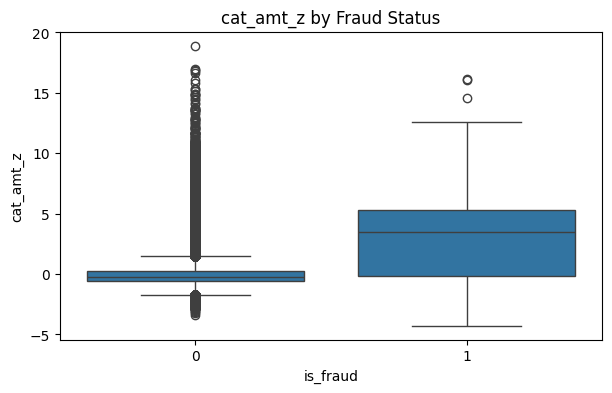

In [62]:
plt.figure(figsize=(7,4))
sns.boxplot(x='is_fraud', y='cat_amt_z', data=cc_df)
plt.title('cat_amt_z by Fraud Status')
plt.show()

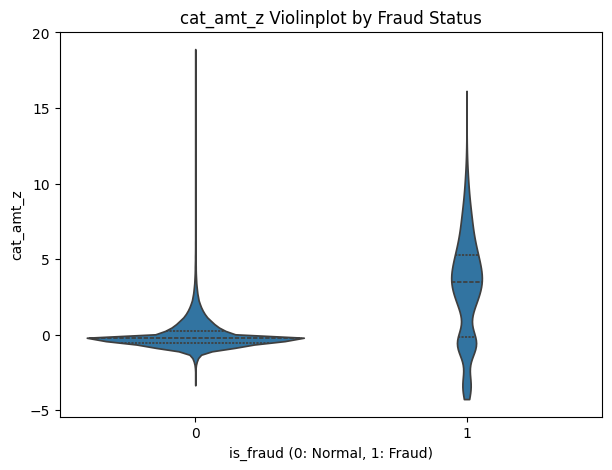

In [66]:
plt.figure(figsize=(7,5))
sns.violinplot(data=cc_df, x='is_fraud', y='cat_amt_z', inner='quartile', cut=0)
plt.title('cat_amt_z Violinplot by Fraud Status')
plt.xlabel('is_fraud (0: Normal, 1: Fraud)')
plt.ylabel('cat_amt_z')
plt.show()

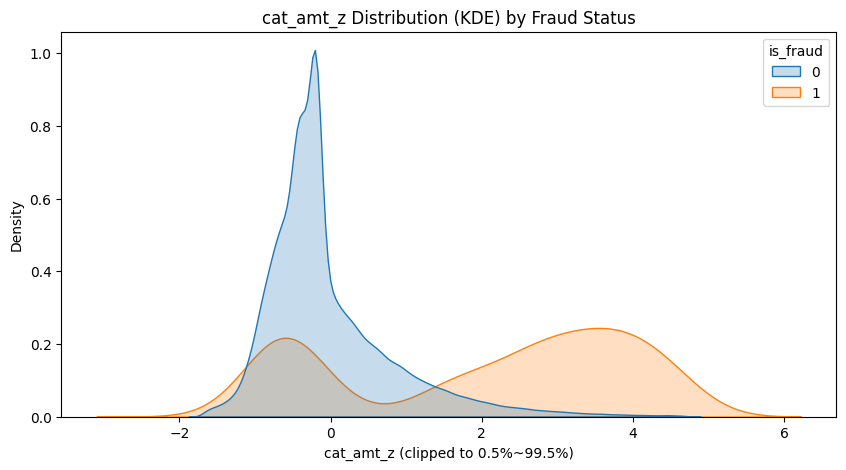

In [65]:
low, high = cc_df['cat_amt_z'].quantile([0.005, 0.995])

plt.figure(figsize=(10,5))
sns.kdeplot(data=cc_df[(cc_df['cat_amt_z']>=low) & (cc_df['cat_amt_z']<=high)],
            x='cat_amt_z', hue='is_fraud', common_norm=False, fill=True)
plt.title('cat_amt_z Distribution (KDE) by Fraud Status')
plt.xlabel('cat_amt_z (clipped to 0.5%~99.5%)')
plt.show()

<br>

##### **amt_z(개인 기준 전체 소비) vs. cat_amt_z(개인 + 업종 기준) 비교 분석**

- 두 Feature의 관계
    >- amt_z는 “이 사람이 평소보다 큰 금액을 썼는지”를,
    >- cat_amt_z는 “이 사람이 그 업종에서 평소보다 큰 금액을 썼는지”를 봄.

- cat_amt_z (개인 + 업종 기준)
    >- 사기 거래(1)의 중앙값이 amt_z보다 더 명확하게 상승
    >- 정상 거래의 극단적 outlier가 상대적으로 줄어듦.
    >- 사기 거래 쪽 분포는 더 “단단한 박스 + 높은 중앙값”

<br>

### **5. Feature Engineering 3** (결제 시간 패턴)

#### **5.1. 시간(hour) 추출**

In [67]:
# trans_date_trans_time 컬럼에서 시간 값을 추출하여 hour 컬럼에 저장
cc_df['trans_date_trans_time'] = pd.to_datetime(cc_df['trans_date_trans_time'])
cc_df['hour'] = cc_df['trans_date_trans_time'].dt.hour

In [68]:
cc_df.head()

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,amt_z,cat_amt_z,hour
0,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,49.159047,-118.186462,0,0.321302,0.317631,0
1,2019-01-01 00:12:34,4956828990005111019,grocery_pos,44.71,M,40.6747,-74.2239,124967,1980-12-21,40.079588,-74.848087,0,-0.114637,-0.652060,0
2,2019-01-01 00:17:16,180048185037117,grocery_net,46.28,F,40.6152,-74.4150,71485,1974-07-19,40.021888,-74.228188,0,-0.361802,-0.723328,0
3,2019-01-01 00:20:15,374930071163758,grocery_pos,64.09,M,42.2203,-83.3583,31515,1971-11-05,42.360426,-83.552316,0,-0.001304,0.211780,0
4,2019-01-01 00:23:41,2712209726293386,misc_pos,25.58,F,30.4066,-91.1468,378909,1977-02-22,29.737426,-90.853194,0,-0.393828,-0.575698,0


<br>

#### **5.2. 시간대를 4개 구간으로 카테고리화 (hour_cat)**

In [69]:
def hour_func(x):
    if (x >= 6) & (x < 12):
        return 'morning'
    elif (x >= 12) & (x < 18):
        return 'afternoon'
    elif (x >= 18) & (x < 23):
        return 'night'
    else:
        return 'evening'

In [71]:
# hour 컬럼에 hour_func 함수를 적용한 값을 hour_cat 컬럼에 저장
cc_df['hour_cat'] = cc_df['hour'].apply(hour_func)

In [72]:
cc_df.head()

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,amt_z,cat_amt_z,hour,hour_cat
0,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,49.159047,-118.186462,0,0.321302,0.317631,0,evening
1,2019-01-01 00:12:34,4956828990005111019,grocery_pos,44.71,M,40.6747,-74.2239,124967,1980-12-21,40.079588,-74.848087,0,-0.114637,-0.652060,0,evening
2,2019-01-01 00:17:16,180048185037117,grocery_net,46.28,F,40.6152,-74.4150,71485,1974-07-19,40.021888,-74.228188,0,-0.361802,-0.723328,0,evening
3,2019-01-01 00:20:15,374930071163758,grocery_pos,64.09,M,42.2203,-83.3583,31515,1971-11-05,42.360426,-83.552316,0,-0.001304,0.211780,0,evening
4,2019-01-01 00:23:41,2712209726293386,misc_pos,25.58,F,30.4066,-91.1468,378909,1977-02-22,29.737426,-90.853194,0,-0.393828,-0.575698,0,evening


<br>

#### **5.3. 시간대별 데이터 수 확인**

In [73]:
# Q. 시간대별로 데이터 수를 계산하여 출력
cc_df['hour_cat'].value_counts()

,count
hour_cat,
afternoon,176801
night,146697
evening,98662
morning,68974


<br>

#### **5.4. 개인별 전체 거래수 대비 시간대별 거래 비율 (hour_perc)**

In [74]:
# cc_num 컬럼의 값마다 amt 컬럼의 데이터 수를 계산하여 all_cnt 변수로 저장
all_cnt = cc_df.groupby('cc_num')['amt'].count().reset_index()

In [75]:
# cc_num, hour_cat 컬럼의 값마다 amt 컬럼의 데이터 수를 계산하여 hour_cnt 변수에 저장
hour_cnt = cc_df.groupby(['cc_num','hour_cat'])['amt'].count().reset_index()

In [77]:
# cc_num 컬럼을 기준으로 hour_cnt와 all_cnt를 합침. (hour_cnt에서 left merge)
hour_cnt = pd.merge(hour_cnt, all_cnt, on='cc_num', how='left')

In [78]:
# amt_x와 amt_y 컬럼의 이름을 각각 hour_cnt, total_cnt로 변경
hour_cnt.rename(columns={'amt_x':'hour_cnt', 'amt_y':'total_cnt'}, inplace=True)

In [79]:
# 전체 거래 건수(total_cnt)에 대한 시간대별 거래 건수(hour_cnt)의 비율을 계산하여 hour_perc 컬럼에 저장
hour_cnt['hour_perc'] = hour_cnt['hour_cnt'] / hour_cnt['total_cnt']

In [80]:
hour_cnt.head()

,cc_num,hour_cat,hour_cnt,total_cnt,amt,hour_perc
0,503874407318,afternoon,1280,3655,3655,0.350205
1,503874407318,evening,737,3655,3655,0.201642
2,503874407318,morning,558,3655,3655,0.152668
3,503874407318,night,1080,3655,3655,0.295486
4,567868110212,afternoon,1228,3644,3644,0.336992


<br>

#### **5.5. hour_perc를 원본 데이터에 merge**

In [81]:
hour_cnt = hour_cnt[['cc_num','hour_cat','hour_perc']]

In [82]:
hour_cnt.to_pickle('./hour_cnt.pkl')

In [83]:
# cc_num, hour_cat 컬럼을 기준으로 cc_df와 hour_cnt 데이터를 합침. (cc_df에서 left merge)
cc_df = pd.merge(cc_df, hour_cnt, on=['cc_num','hour_cat'], how='left')

In [84]:
cc_df.head()

,trans_date_trans_time,cc_num,category,amt,gender,lat,long,city_pop,dob,merch_lat,merch_long,is_fraud,amt_z,cat_amt_z,hour,hour_cat,hour_perc
0,2019-01-01 00:00:44,630423337322,grocery_pos,107.23,F,48.8878,-118.2105,149,1978-06-21,49.159047,-118.186462,0,0.321302,0.317631,0,evening,0.196470
1,2019-01-01 00:12:34,4956828990005111019,grocery_pos,44.71,M,40.6747,-74.2239,124967,1980-12-21,40.079588,-74.848087,0,-0.114637,-0.652060,0,evening,0.214383
2,2019-01-01 00:17:16,180048185037117,grocery_net,46.28,F,40.6152,-74.4150,71485,1974-07-19,40.021888,-74.228188,0,-0.361802,-0.723328,0,evening,0.217252
3,2019-01-01 00:20:15,374930071163758,grocery_pos,64.09,M,42.2203,-83.3583,31515,1971-11-05,42.360426,-83.552316,0,-0.001304,0.211780,0,evening,0.213600
4,2019-01-01 00:23:41,2712209726293386,misc_pos,25.58,F,30.4066,-91.1468,378909,1977-02-22,29.737426,-90.853194,0,-0.393828,-0.575698,0,evening,0.202882


<br>

#### **5.6. 사기/정상에서 hour_perc 분포 차이 확인**

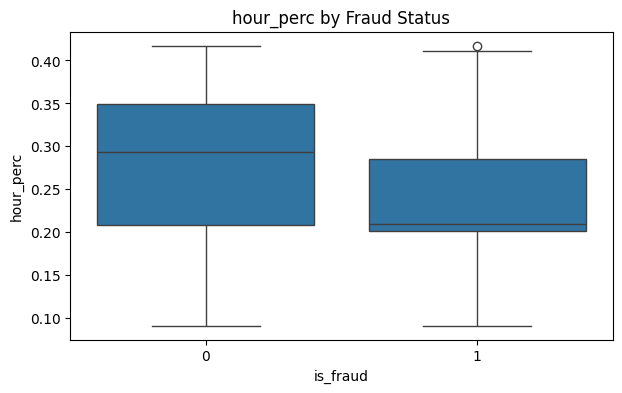

In [85]:
plt.figure(figsize=(7,4))
sns.boxplot(x='is_fraud', y='hour_perc', data=cc_df)
plt.title('hour_perc by Fraud Status')
plt.show()

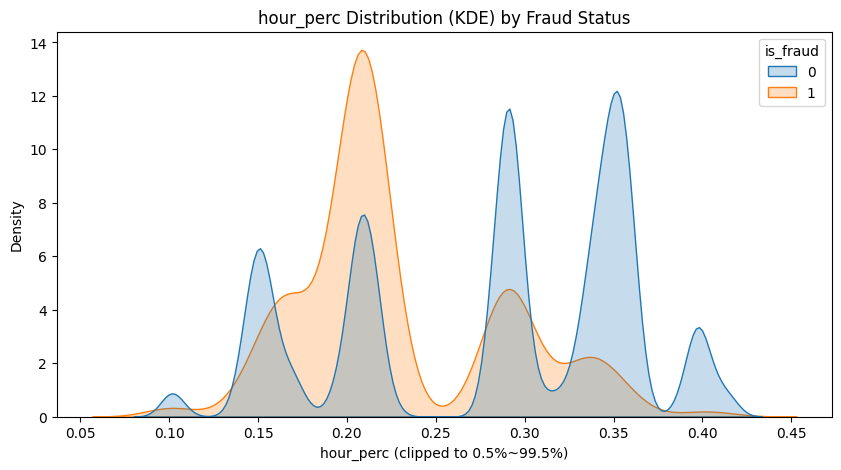

In [86]:
low, high = cc_df['hour_perc'].quantile([0.005, 0.995])

plt.figure(figsize=(10,5))
sns.kdeplot(data=cc_df[(cc_df['hour_perc']>=low) & (cc_df['hour_perc']<=high)],
            x='hour_perc', hue='is_fraud', common_norm=False, fill=True)
plt.title('hour_perc Distribution (KDE) by Fraud Status')
plt.xlabel('hour_perc (clipped to 0.5%~99.5%)')
plt.show()

##### **hour_perc 분포 분석**

- 중앙 경향 차이
> 사기 거래(is_fraud=1)의 hour_perc 중앙값이 정상 거래 대비 더 낮게 나타나, 사기 거래가 사용자의 비주요 활동 시간대에 발생하는 경향을 보임.

- 분포 중첩 존재
> 두 집단의 분포가 일부 구간에서 중첩되어 있어, 시간 정보만으로 사기 여부를 단독 판단하기에는 한계가 존재함.

- 해석 및 활용 방향
> hour_perc는 단독 판별 지표라기보다는, 결제 금액(amt_z, cat_amt_z) 등 강한 이상성 지표와 결합될 때 보조적인 설명력을 제공하는 feature로 해석하는 것이 타당함.

<br>

### **6. Feature Engineering 4** (거리 기반 이상 패턴)

#### **6.1. 거리 계산 라이브러리 설치 및 적용**

In [87]:
!pip install geopy

In [88]:
from geopy.distance import distance

In [89]:
# 고객 위치(lat,long)와 상점 위치(merch_lat, merch_long) 사이 거리(km)
# (모든 row에 적용되어 시간이 오래 걸릴 수 있음)

In [90]:
cc_df['distance'] = cc_df.apply(
    lambda x: distance((x['lat'], x['long']), (x['merch_lat'], x['merch_long'])).km,
    axis=1
)

In [91]:
cc_df[['distance']].head()

,distance
0,30.216618
1,84.714605
2,67.768167
3,22.322745
4,79.398244


<br>

#### **6.2. 개인별 거리 평균/표준편차(dist_info) → merge**

In [92]:
# cc_num 컬럼의 값마다 distance의 평균, 표준편차를 계산하여 dist_info 변수에 저장
dist_info = cc_df.groupby('cc_num')['distance'].agg(['mean','std']).reset_index()

In [93]:
dist_info.head()

,cc_num,mean,std
0,503874407318,79.746738,29.741044
1,567868110212,79.356969,30.524201
2,571365235126,73.651715,28.863007
3,581686439828,74.428143,28.605102
4,630423337322,71.656621,28.090646


In [94]:
dist_info.to_pickle('./dist_info.pkl')

In [95]:
# Q. cc_num 컬럼을 기준으로 cc_df와 dist_info 데이터를 합침. (cc_df에서 left merge)
cc_df = pd.merge(cc_df, dist_info, on='cc_num', how='left')

In [96]:
cc_df.shape  # 병합이 잘못되면 row가 급증할 수 있으므로 shape 확인

(491134, 20)

In [97]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  491134 non-null  datetime64[ns]
 1   cc_num                 491134 non-null  int64         
 2   category               491134 non-null  object        
 3   amt                    491134 non-null  float64       
 4   gender                 491134 non-null  object        
 5   lat                    491134 non-null  float64       
 6   long                   491134 non-null  float64       
 7   city_pop               491134 non-null  int64         
 8   dob                    491134 non-null  object        
 9   merch_lat              491134 non-null  float64       
 10  merch_long             491134 non-null  float64       
 11  is_fraud               491134 non-null  int64         
 12  amt_z                  491134 non-null  floa

<br>

#### **6.3. dist_z 생성**

In [98]:
# distance 값의 z-score를 계산하여 dist_z 컬럼에 저장
cc_df['dist_z'] = (cc_df['distance'] - cc_df['mean']) / cc_df['std']

In [99]:
# (안전장치) inf/NaN 정리
cc_df['dist_z'] = cc_df['dist_z'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [101]:
cc_df[['distance','dist_z']].head()

,distance,dist_z
0,30.216618,-1.475224
1,84.714605,0.345370
2,67.768167,-0.272693
3,22.322745,-1.824486
4,79.398244,0.002138


<br>

#### **6.4 사기/정상에서 dist_z 분포 차이**

- dist_z가 사기와 관련 있는지 확인

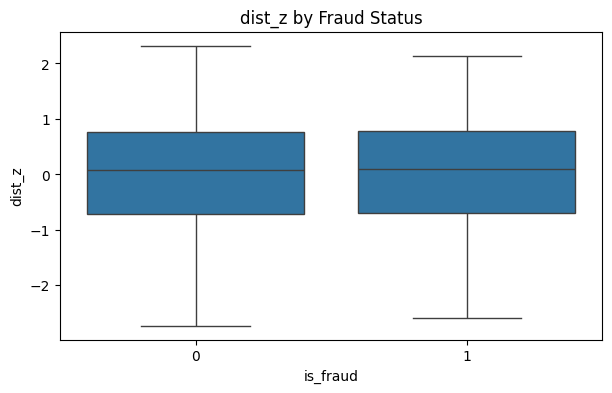

In [102]:
plt.figure(figsize=(7,4))
sns.boxplot(x='is_fraud', y='dist_z', data=cc_df)
plt.title('dist_z by Fraud Status')
plt.show()

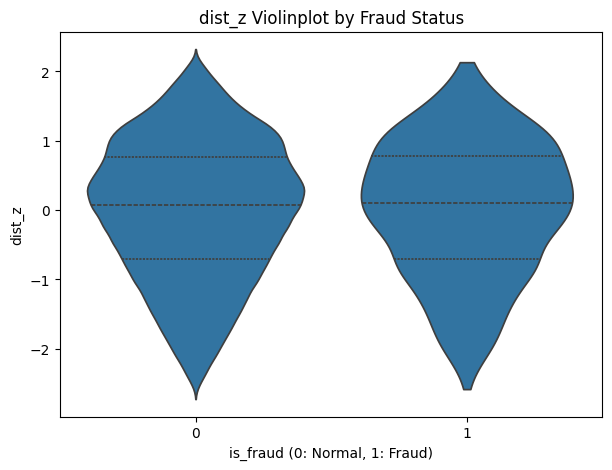

In [104]:
plt.figure(figsize=(7,5))
sns.violinplot(data=cc_df, x='is_fraud', y='dist_z', inner='quartile', cut=0)
plt.title('dist_z Violinplot by Fraud Status')
plt.xlabel('is_fraud (0: Normal, 1: Fraud)')
plt.ylabel('dist_z')
plt.show()

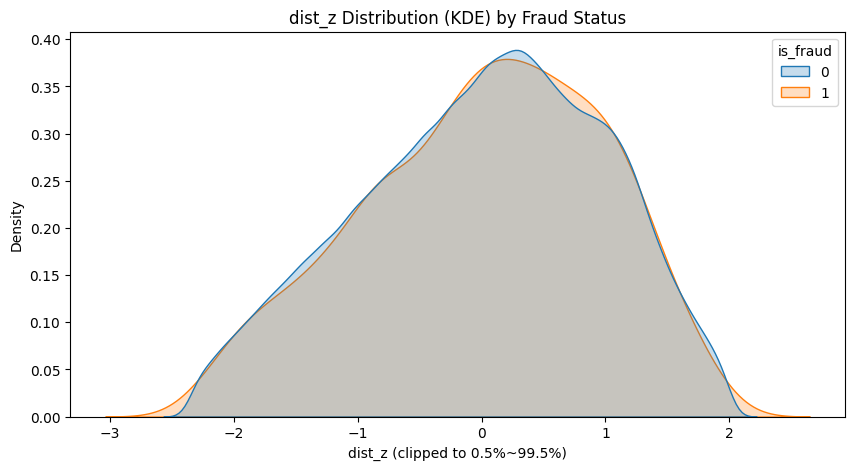

In [103]:
low, high = cc_df['dist_z'].quantile([0.005, 0.995])

plt.figure(figsize=(10,5))
sns.kdeplot(data=cc_df[(cc_df['dist_z']>=low) & (cc_df['dist_z']<=high)],
            x='dist_z', hue='is_fraud', common_norm=False, fill=True)
plt.title('dist_z Distribution (KDE) by Fraud Status')
plt.xlabel('dist_z (clipped to 0.5%~99.5%)')
plt.show()

##### **dist_z 데이터 분포 분석**

- dist_z는 거래 발생 위치의 이례성을 나타내는 변수이나, 본 데이터에서는 위치 변화 자체가 사기 여부를 직접적으로 설명하는 핵심 요인으로 작용하지 않는 것으로 판단됨.
- dist_z는 사기 거래와 정상 거래 간 분포 차이가 제한적이며, 단독으로는 판별력이 낮은 보조적 특성으로 판단됨.

<br>

### **7. 나이 Feature + 범주형 인코딩(One-hot)**

#### **7.1. dob에서 연도만 추출**

In [105]:
# dob 컬럼에서 연도 값만 추출하여 dob 컬럼에 저장
cc_df['dob'] = pd.to_datetime(cc_df['dob']).dt.year

In [106]:
cc_df['dob'].head()

,dob
0,1978
1,1980
2,1974
3,1971
4,1977


- “출생연도(dob)” 자체보다 “나이(age)”가 더 직관적인 경우가 많아 보완으로 age를 추가

In [107]:
# (보완) 나이 feature 생성: 데이터 기준 연도는 과제/데이터 시점에 맞춰 고정
# 보통은 거래 연도 기준이지만, 여기서는 과제 제출용으로 고정(예: 2026)

In [108]:
cc_df['age'] = 2026 - cc_df['dob']

In [109]:
cc_df['age'].head()

,age
0,48
1,46
2,52
3,55
4,49


In [110]:
cc_df.drop('dob', axis=1, inplace=True)

In [111]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   trans_date_trans_time  491134 non-null  datetime64[ns]
 1   cc_num                 491134 non-null  int64         
 2   category               491134 non-null  object        
 3   amt                    491134 non-null  float64       
 4   gender                 491134 non-null  object        
 5   lat                    491134 non-null  float64       
 6   long                   491134 non-null  float64       
 7   city_pop               491134 non-null  int64         
 8   merch_lat              491134 non-null  float64       
 9   merch_long             491134 non-null  float64       
 10  is_fraud               491134 non-null  int64         
 11  amt_z                  491134 non-null  float64       
 12  cat_amt_z              491134 non-null  floa

<br>

#### **7.2. category/gender 원-핫 인코딩 (Task)**

In [112]:
cc_df['category'].nunique()

14

In [113]:
# cc_df의 범주형 데이터에 원-핫 인코딩을 적용
cc_df = pd.get_dummies(cc_df, columns=['category','gender'], drop_first=True, dtype=int)

In [114]:
cc_df.head()

,trans_date_trans_time,cc_num,amt,lat,long,city_pop,merch_lat,merch_long,is_fraud,amt_z,cat_amt_z,hour,hour_cat,hour_perc,distance,mean,std,dist_z,age,category_food_dining,category_gas_transport,category_grocery_net,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,gender_M
0,2019-01-01 00:00:44,630423337322,107.23,48.8878,-118.2105,149,49.159047,-118.186462,0,0.321302,0.317631,0,evening,0.196470,30.216618,71.656621,28.090646,-1.475224,48,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2019-01-01 00:12:34,4956828990005111019,44.71,40.6747,-74.2239,124967,40.079588,-74.848087,0,-0.114637,-0.652060,0,evening,0.214383,84.714605,74.811123,28.675031,0.345370,46,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,2019-01-01 00:17:16,180048185037117,46.28,40.6152,-74.4150,71485,40.021888,-74.228188,0,-0.361802,-0.723328,0,evening,0.217252,67.768167,75.617531,28.784606,-0.272693,52,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,2019-01-01 00:20:15,374930071163758,64.09,42.2203,-83.3583,31515,42.360426,-83.552316,0,-0.001304,0.211780,0,evening,0.213600,22.322745,74.706461,28.711493,-1.824486,55,0,0,0,1,0,0,0,0,0,0,0,0,0,1
4,2019-01-01 00:23:41,2712209726293386,25.58,30.4066,-91.1468,378909,29.737426,-90.853194,0,-0.393828,-0.575698,0,evening,0.202882,79.398244,79.334924,29.620117,0.002138,49,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [115]:
cc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491134 entries, 0 to 491133
Data columns (total 33 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   trans_date_trans_time    491134 non-null  datetime64[ns]
 1   cc_num                   491134 non-null  int64         
 2   amt                      491134 non-null  float64       
 3   lat                      491134 non-null  float64       
 4   long                     491134 non-null  float64       
 5   city_pop                 491134 non-null  int64         
 6   merch_lat                491134 non-null  float64       
 7   merch_long               491134 non-null  float64       
 8   is_fraud                 491134 non-null  int64         
 9   amt_z                    491134 non-null  float64       
 10  cat_amt_z                491134 non-null  float64       
 11  hour                     491134 non-null  int32         
 12  hour_cat        

In [116]:
cc_df.drop('cc_num', axis=1, inplace=True)

<br>

#### **7.3. 최종 품질 점검**

In [117]:
cc_df.shape

(491134, 32)

In [118]:
cc_df.dtypes.value_counts()

,count
int64,16
float64,12
int32,2
datetime64[ns],1
object,1


In [119]:
# 결측/무한대 최종 점검

In [120]:
np.isinf(cc_df.select_dtypes(include=[np.number])).sum().sum()

np.int64(0)

In [121]:
cc_df.isna().sum().sum()

np.int64(0)

<br>

## **루브릭**

---

#### **루브릭 평가 표**

| 평가문항 | 상세기준 |
|---|---|
| **1. 컬럼 이름의 변경 및 결측치 처리** | 컬럼 이름의 변경이 명확하게 반영되어 있고, 다양한 방법으로 효과적인 결측치 처리를 진행할 수 있는가? |
| **2. 이상치 감지 및 수정** | 데이터의 이상치를 감지하여 수정하고, 수정 후 데이터의 일관성이 유지되며 품질 또한 향상되었는가? |
| **3. 추가 변수 생성** | 추가적인 변수를 창의적으로 생성하고 유용하게 데이터 분석에 기여하였는가? |


<br>

#### **1. 컬럼 이름 변경 및 결측치 처리**

- 본 프로젝트에서는 원본 데이터의 컬럼명을 의미가 명확하도록 정리하여 변수의 해석 가능성을 높였다.

- 이를 통해 각 컬럼이 나타내는 정보가 직관적으로 드러나도록 하였으며, 이후 분석 단계에서 혼동을 줄였다.

- 결측치 처리 과정에서는 단일 방식에 의존하지 않고, 변수의 성격에 따라 평균·중앙값 대체, 비율 기반 변수 생성 시 결측 제거 등 다양한 방법을 상황에 맞게 적용하였다.

- 그 결과 데이터 손실을 최소화하면서도 분석에 활용 가능한 형태로 데이터를 정제할 수 있었다.

<br>

#### **2. 이상치 감지 및 수정**

- Z-score 기반 지표(amt_z, cat_amt_z, dist_z)와 시각화(Boxplot, KDE)를 활용하여 데이터 내 이상치를 체계적으로 탐지하였다.

- 이를 통해 극단적인 값이 존재하는 변수와 그렇지 않은 변수를 구분할 수 있었다.

- 이상치 처리 시에는 무작정 제거하기보다는, 필요에 따라 클리핑(clipping) 등 데이터의 분포 특성과 일관성을 유지하는 방식을 적용하였다.

- 그 결과 이상치로 인한 왜곡을 완화하면서도 데이터의 전체적인 품질과 신뢰도를 향상시킬 수 있었다.

<br>

#### **3. 추가 변수 생성**

- 기존 변수들을 기반으로 개인 소비 패턴 및 맥락 정보를 반영한 파생 변수를 생성하였다.

- 대표적으로 개인 기준 결제 이례성을 나타내는 amt_z, 업종까지 고려한 cat_amt_z, 시간대 사용 패턴을 반영한 hour_perc, 위치 기반 이례성을 나타내는 dist_z 등을 도출하였다.

- 이러한 파생 변수들은 단순 원본 변수보다 사기 거래와의 관계를 더 명확히 드러내며,

- 특히 금액·시간·위치 정보를 다각도로 결합함으로써 데이터 분석 및 사기 탐지에 실질적으로 기여하는 feature로 활용될 수 있음을 확인하였다.

<br>

#### **한 줄 총평**

> 데이터 정제, 이상치 처리, 그리고 맥락을 고려한 파생 변수 생성을 단계적으로 수행함으로써, 분석 목적에 부합하는 고품질 데이터셋을 구성하고 각 전처리 단계의 의미를 이해하며 프로젝트를 수행하였다.